# Анализ рынка заведений общественного питания Москвы

Заказчик решил открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами заказчик решился обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import requests
from bs4 import BeautifulSoup
import matplotlib.style as style

In [2]:
data = pd.read_csv('rest_data.csv')

# Шаг 1. Подготовка данных.

In [3]:
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [4]:
data['chain'] = data['chain'].apply(lambda x: True if x=='да' else False)

Проверим остальные колонки

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  bool  
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: bool(1), int64(2), object(3)
memory usage: 615.4+ KB


Ничего подозрительного

Проверим, есть ли дубликаты в колонке object_name среди несетевых заведений. Для этого сначала переведём все названия в нижний регистр

In [6]:
data['object_name'] = data['object_name'].str.lower()

data = data[np.logical_not(np.logical_and(data['chain']==False, data.duplicated('object_name')))]

In [7]:
len(data)

12331

Дубликаты были, но мы их убрали – строчек стало меньше. Теперь проверим, есть ли пропуски в колонках.

In [11]:
data = data[np.logical_not(data.isna().any(axis=1))]
len(data)

12331

Теперь разберёмся с заведениями, у которых есть приписки вроде "кафе" или "столовая" в столбике object_name. Эти приписки нужно убрать, чтобы избавиться от неявных дубликатов. Перед чисткой посмотрим, сколько всего уникальных названий сетевых заведений в столбике.

In [12]:
len(sorted(list(data[data['chain'] == True]['object_name'].unique())))

577

In [13]:
object_types = data['object_type'].unique()

def clean_name(name):
    name = name.split(' ')
    for x in name:
        if x in object_types:
            name.remove(x)
    return ' '.join(name)

data['object_name'] = data['object_name'].apply(lambda x: clean_name(x))

In [14]:
len(sorted(list(data[data['chain'] == True]['object_name'].unique())))

531

Стало лучше. Также я заметил, что есть различные варианты записи KFC и Мята Lounge, исправим.

In [15]:
data['object_name'] = data['object_name'].apply(
    lambda x:'kfc' if 'kfc' in x else x).apply(
    lambda x:'мята lounge' if 'мята lounge' in x else x)

In [16]:
len(sorted(list(data[data['chain'] == True]['object_name'].unique())))

515

Теперь избавимся от дубликтов вроде семейное кафе "Андерсон" и кафе "Андерсон"


In [17]:
def remove_quotes(x):
    try:
        return re.search('(?<=\«)(.*?)(?=\»)', x).group(0)
    except:
        return x

data['object_name'] = data['object_name'].apply(lambda x: remove_quotes(x))

In [18]:
len(sorted(list(data[data['chain'] == True]['object_name'].unique())))

403

# Шаг 2. Анализ данных.

### 1 Типы объектов общественного питания

/Users/leonidharlov/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'количество заведений')]

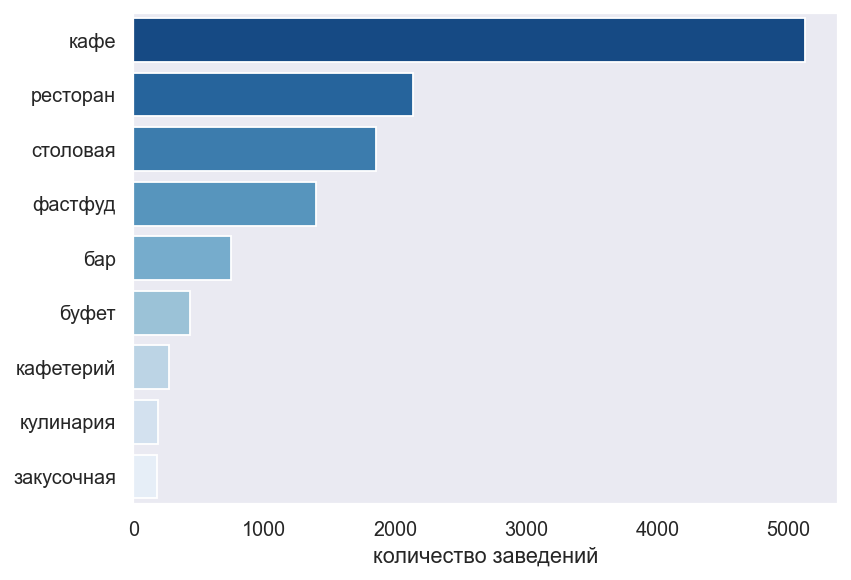

In [24]:
plt.figure(figsize=(7,5),dpi=130)
sns.set(style="dark")
ax=sns.barplot(data['object_type'].value_counts().values,
            ['кафе','ресторан','столовая','фастфуд','бар','буфет','кафетерий','кулинария','закусочная'],
            palette='Blues_r',saturation=0.8)
ax.set(xlabel='количество заведений')

Кафе – лидер по распространённости в Москве, за ними следуют рестораны и столовые.

### 2  Распространённость сетевых объектов питания¶

/Users/leonidharlov/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

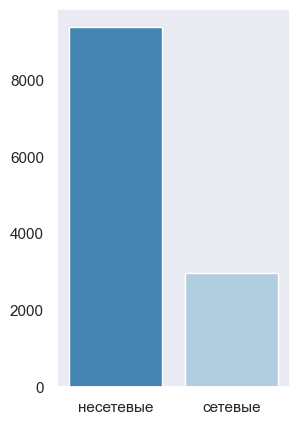

In [25]:
plt.figure(figsize=(3,5),dpi=100)
sns.set_style("dark")
sns.barplot(['несетевые','сетевые'],
            data['chain'].value_counts().values,
            palette='Blues_r',saturation=0.8)

Сетевые заведения гораздо менее распространены, чем несетевые

### 3 Для какого вида объекта общественного питания характерно сетевое распространение?

In [26]:
chain_ratio = data.groupby('object_type').agg({'chain':'sum','object_name':'count'}).reset_index()
chain_ratio.columns=['object_type','chains','objects_total']
chain_ratio['chains']=chain_ratio['chains'].apply(lambda x:int(x))
chain_ratio['chain_percent'] = chain_ratio['chains'] / chain_ratio['objects_total']
chain_ratio

,object_type,chains,objects_total,chain_percent
0,бар,37,747,0.049531
1,буфет,11,433,0.025404
2,закусочная,56,180,0.311111
3,кафе,1396,5126,0.272337
4,кафетерий,52,276,0.188406
5,магазин (отдел кулинарии),78,186,0.419355
6,предприятие быстрого обслуживания,791,1393,0.567839
7,ресторан,544,2133,0.255040
8,столовая,3,1857,0.001616


<AxesSubplot:>

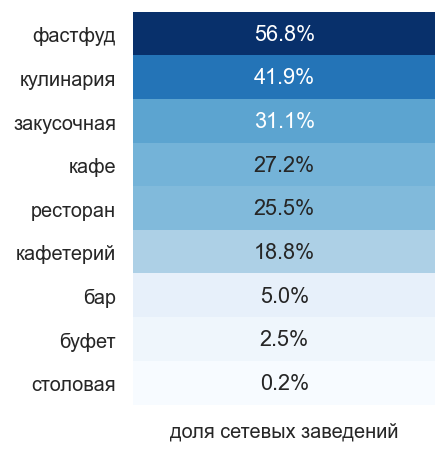

In [30]:
chain_heatmap=chain_ratio[['object_type','chain_percent']].replace(
    {'предприятие быстрого обслуживания':'фастфуд','магазин (отдел кулинарии)':'кулинария'})
chain_heatmap.columns=['','доля сетевых заведений']
chain_heatmap=chain_heatmap.set_index('').sort_values('доля сетевых заведений',ascending=False)

plt.figure(figsize=(3,4),dpi=130)

sns.set_style("dark")
sns.heatmap(chain_heatmap, annot=True, fmt=".1%", cmap="Blues",cbar=False)

Больше всего в городе сетевых кафе, но это только из-за того что кафе много в принципе. Наибольший доля сетевых объектов наблюдается среди предприятий быстрого обслуживания – 56.8% из них попадают в эту категорию, далее идут магазины и закусочные. Кафе же занимают четвёртое место по проценту сетевых предприятий с показателем в 27.2%.


### 4 Характеристики сетевых заведений

Мы планируем открыть кафе, поэтому сведения о магазинах-кулинариях, в которых 0 посадочных мест, лишь искажают данные. Для построения графиков и подсчёта средних значений, можно от них избавиться.


/Users/leonidharlov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/leonidharlov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


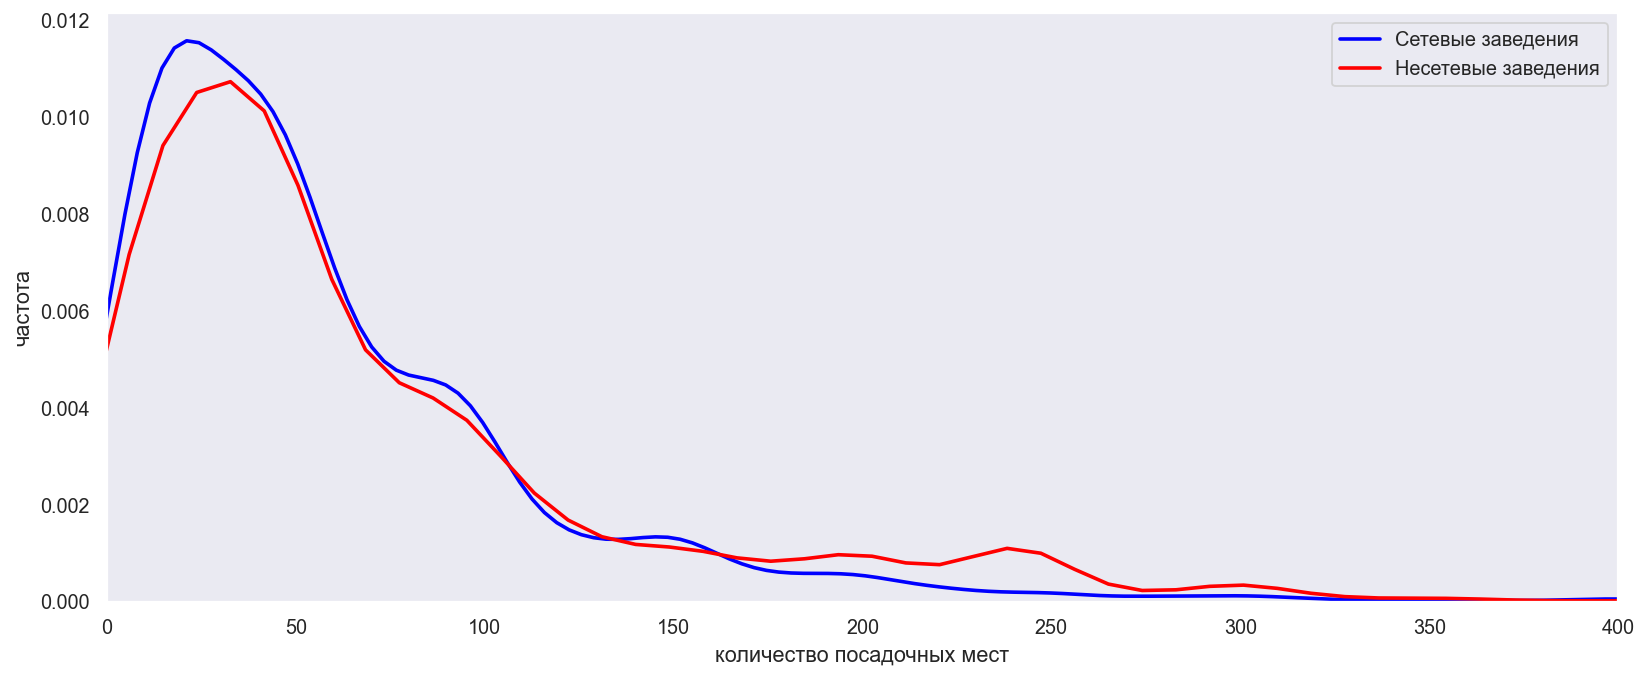

In [31]:
networks = data[np.logical_and(data['chain']==True, data['number']!=0)]['number']
non_networks = data[np.logical_and(data['chain']==False, data['number']!=0)]['number']

plt.figure(figsize=(15,6),dpi=130)

sns.set_style("dark")

ax0=sns.distplot(networks,kde_kws=dict(linewidth=2,alpha=0.5),
                 hist_kws=dict(alpha=0.3),color='blue',
                 label='Сетевые заведения',hist=False)

ax1=sns.distplot(non_networks, kde_kws=dict(linewidth=2,alpha=0.5), 
                 hist_kws=dict(alpha=0.3),color='red',
                 label='Несетевые заведения',hist=False)

ax0.set(xlabel='количество посадочных мест', ylabel='частота')
plt.xlim(0, 400)
plt.legend()

По графику видно, что сетевые заведения чаще располагают меньшим количеством мест, чем несетевые. Посмотрим на цифры:


In [32]:
'Чаще всего в сетевых заведениях {} мест. Медианное значение количества мест – {}, а среднее – {}'.format(
    int(networks.mode()),networks.median(), round(networks.mean(),1))

'Чаще всего в сетевых заведениях 20 мест. Медианное значение количества мест – 43.0, а среднее – 58.2'

In [33]:
'В несетевых заведениях чаще всего {} мест. Медианное значение количества мест – {}, а среднее – {}'.format(
    int(non_networks.mode()),non_networks.median(), round(non_networks.mean(),1))

'В несетевых заведениях чаще всего 40 мест. Медианное значение количества мест – 45.0, а среднее – 71.5'

То, что видно на графике, подтвердилось в цифрах

Теперь посмотрим на диаграмму рассеяния по количеству мест и количеству заведений. Для этого создадим датасет по сетям и избавимся от выбросов

In [34]:
networks = data[np.logical_and(data['chain']==True, data['number']!=0)].groupby('object_name').agg(
                    {'address':'count','number':'median'})
print(np.percentile(networks['address'],[5,95]))
print(np.percentile(networks['number'],[5,95]))

[ 1. 31.]
[  6.775 154.5  ]


Оставим только те сети, у которых от 2 до 30 точек и медианное количество мест – от 7 до 154.

In [36]:
networks = networks[np.logical_and(np.logical_and(networks['address'] < 31, networks['address'] > 1), 
                                   np.logical_and(networks['number'] <= 154, networks['number'] >= 7))]

(0.0, 151.85)

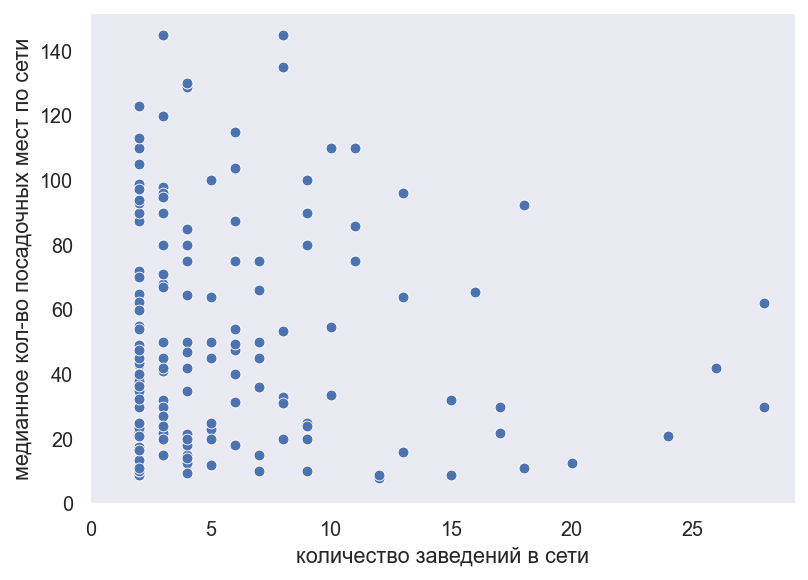

In [37]:
plt.figure(figsize=(7,5),dpi=130)

sns.set_style("dark")
ax=sns.scatterplot(x="address", y="number", 
                data=networks)
ax.set(xlabel='количество заведений в сети', ylabel='медианное кол-во посадочных мест по сети')
ax.set_xlim(0)
ax.set_ylim(0)

In [38]:
networks['number'].describe()

count    161.000000
mean      52.440994
std       35.415012
min        8.000000
25%       22.000000
50%       43.500000
75%       75.000000
max      145.000000
Name: number, dtype: float64

Сетям свойственно иметь от 2 до 4 точек c количеством посадочных мест от 22 до 75

### 5 Среднее количество посадочных мест по видам заведений

In [39]:
seats = data.groupby('object_type').agg({'number':'mean'}).sort_values('number',ascending=False).reset_index()

seats['object_type']=seats['object_type'].replace(
    {'предприятие быстрого обслуживания':'фастфуд','магазин (отдел кулинарии)':'кулинария'})

/Users/leonidharlov/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


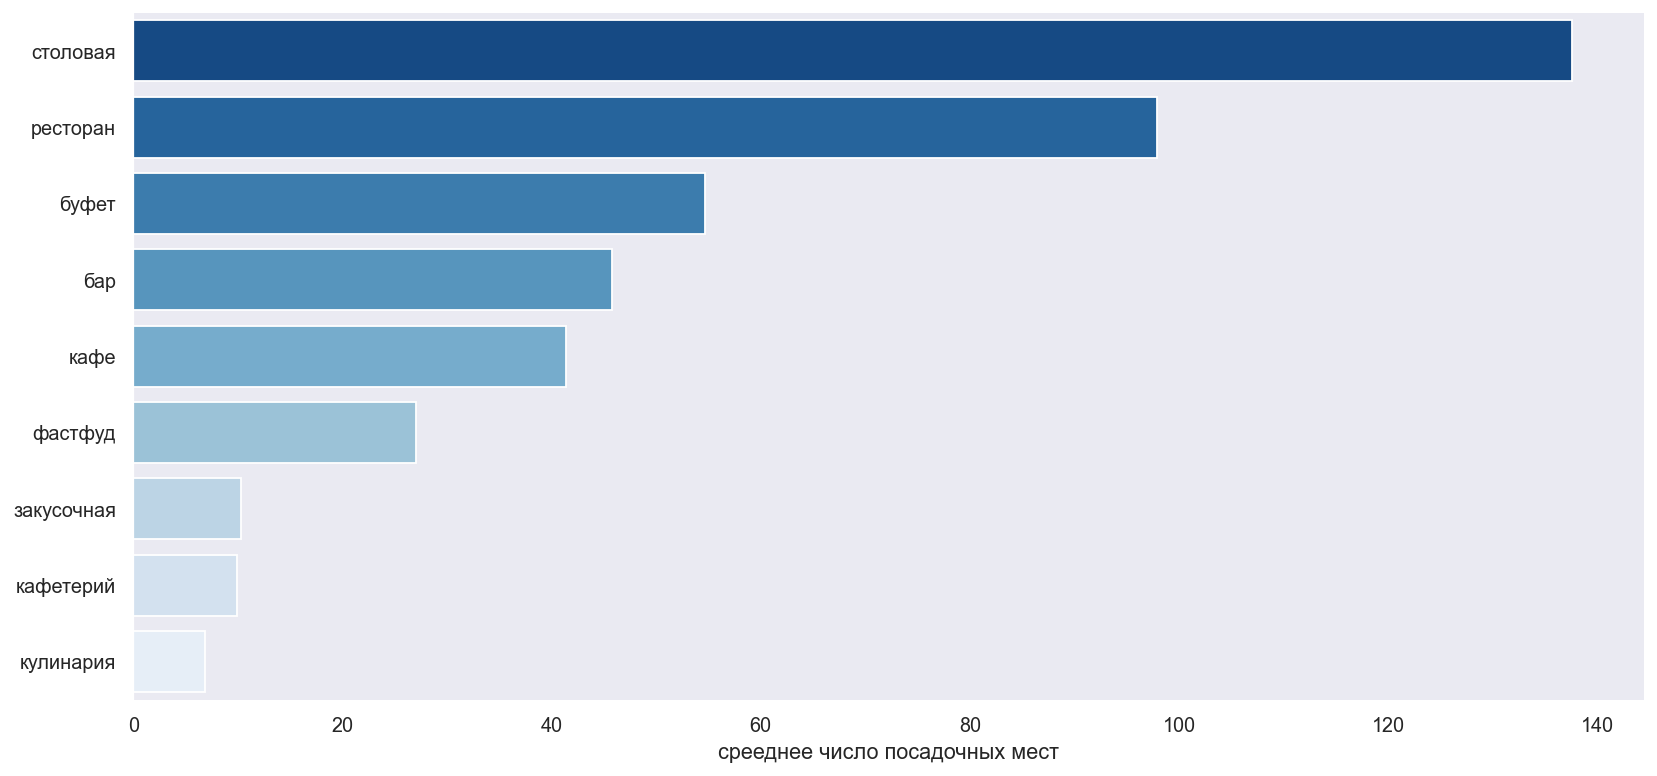

In [40]:
plt.figure(figsize=(15,7),dpi=130)

sns.set_style("dark")
ax = sns.barplot(seats['number'],seats['object_type'],
            palette='Blues_r',saturation=0.8)
ax.set(xlabel='срееднее число посадочных мест', ylabel='')
sns.despine(bottom=True)

В среднем в столовых больше всего посадочных мест, далее со значительным отрывом идут рестораны и буфеты


### 6 Топ-10 улиц по количеству объектов общественного питания

Напишем метод для определения района по улице


In [42]:
def define_district(street):
    URL = 'https://geocode-maps.yandex.ru/1.x'
    key = 'a943a2d7-25f9-41b6-845c-1a7d1eb00f27'
    PARAM={'geocode':'Москва,'+street,
           'apikey':key
          }
    req = requests.get(url = URL, params = PARAM)
    soup=BeautifulSoup(req.text, 'lxml')
    
    coordinates = soup.find('pos').text
    
    PARAM={'geocode':coordinates, 
           'kind':'district',
           'apikey':key
          }
    req = requests.get(url = URL, params = PARAM)
    soup=BeautifulSoup(req.text, 'lxml')
    
    try:
        return re.findall('<DependentLocalityName>(.*?)</DependentLocalityName>',req.text)[1]
    except:
        return 'none'

В датафрейме создадим отдельный столбик только для улицы


In [43]:
data['street'] = data['address'].apply(lambda x: x.split(',')[1])

Подготовим топ улиц по количеству заведений и добавим в получившуюся таблицу районы

In [44]:
streets = data.groupby('street')['object_name'].count().sort_values(ascending=False).reset_index()
streets.columns=['street','objects']
top_streets = streets.head(11)[1:]

top_streets['district'] = top_streets['street'].apply(lambda x: define_district(x))

In [45]:
top_streets

,street,objects,district
1,проспект Мира,181,Алексеевский район
2,Профсоюзная улица,155,район Коньково
3,Ленинградский проспект,153,Хорошёвский район
4,Пресненская набережная,148,Пресненский район
5,Варшавское шоссе,137,none
6,Ленинский проспект,122,Ломоносовский район
7,проспект Вернадского,108,Ломоносовский район
8,поселение Сосенское,100,административно-деловой центр Коммунарка
9,Кутузовский проспект,98,район Дорогомилово
10,Кировоградская улица,89,район Чертаново Центральное


Почти все улицы в топе находятся за пределами 3-го транспортного кольца (исключение – Кутузовский проспект и Пресненская набережная) и сразу две из них оказались в Ломоносовском районе

Для наглядности построим столбчатую диаграмму по количеству заведений на этих улицах

/Users/leonidharlov/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


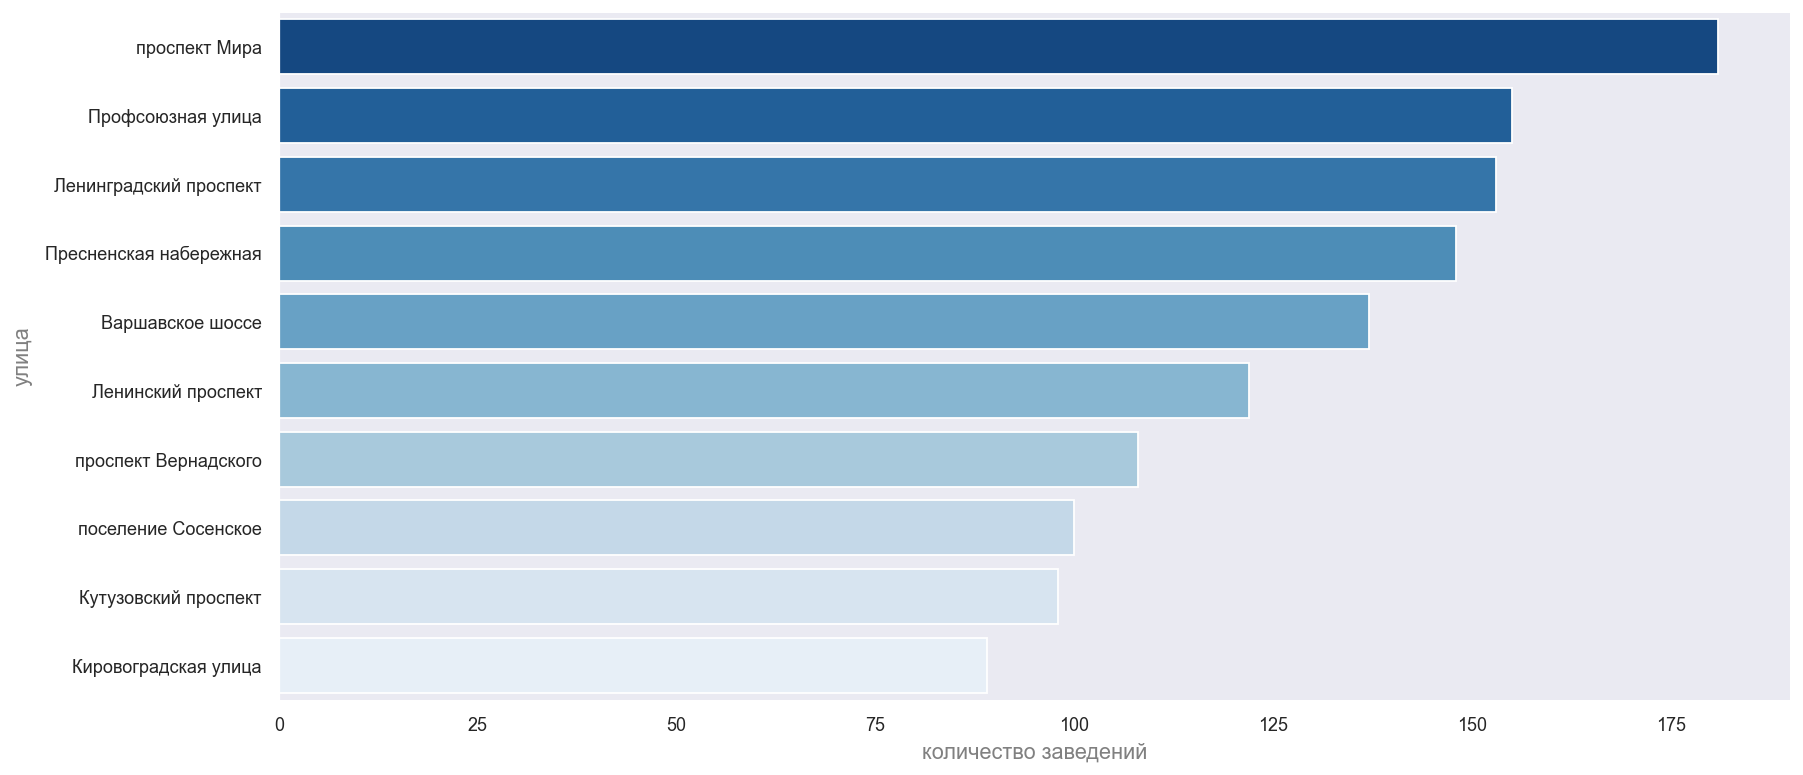

In [46]:
plt.figure(figsize=(15,7),dpi=130)

sns.set_style("dark")
ax1 = sns.barplot(top_streets['objects'],top_streets['street'],
            palette='Blues_r',saturation=0.8)

ax1.set_xlabel("количество заведений",color='grey')
ax1.set_ylabel("улица",color='grey')
ax1.tick_params(labelsize=10)

sns.despine(bottom=True)

### 7 Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания

Построим гистограму распределения количества мест в заведениях с улиц из топа и в заведениях с улиц не из топа

In [47]:
top_streets_data = data[data['street'].isin(list(top_streets['street']))]['number']
non_top_streets_data = data[~data['street'].isin(list(top_streets['street']))]['number']

/Users/leonidharlov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leonidharlov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


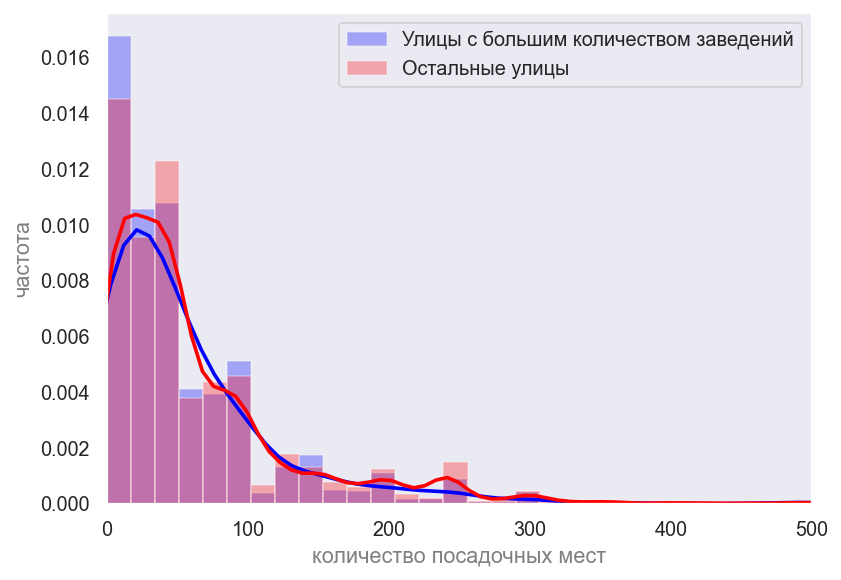

In [48]:
plt.figure(figsize=(7,5),dpi=130)

sns.set_style("dark")

ax0=sns.distplot(top_streets_data,bins=100,kde_kws=dict(linewidth=2,alpha=0.5),
                 hist_kws=dict(alpha=0.3),color='blue',
                 label='Улицы с большим количеством заведений')

ax1=sns.distplot(non_top_streets_data,bins=88,kde_kws=dict(linewidth=2,alpha=0.5), 
                 hist_kws=dict(alpha=0.3),color='red',label='Остальные улицы')

ax0.set_xlabel('количество посадочных мест',color='grey')
ax0.set_ylabel('частота',color='grey')

plt.xlim(0, 500)
plt.legend()

По сравнению с остальными заведениями, заведения на улицах в топе чаще предлагают меньшее количество посадочных мест

In [49]:
'Медианное количество мест в заведениях из топа – {}, а среднее – {}'.format(
    top_streets_data.median(), round(top_streets_data.mean(),1))

'Медианное количество мест в заведениях из топа – 40.0, а среднее – 57.7'

In [50]:
'Медианное количество мест в заведениях не из топа – {}, а среднее – {}'.format(
    non_top_streets_data.median(), round(non_top_streets_data.mean(),1))

'Медианное количество мест в заведениях не из топа – 40.0, а среднее – 63.7'

### 8 Улицы с одним  объектом общественного питания

Соберём датафрейм по улицам с одним объектом общественного питания и определим районы этих улиц и избавимся от случайно попавших сюда улиц, которые на самом деле не улицы (например, "Дом 5/1")

In [51]:
poor_streets = streets[streets['objects']==1]
poor_streets=poor_streets[~poor_streets['street'].str.contains('дом(.*?)', regex=True)]

poor_streets['district'] = poor_streets['street'].apply(lambda x: define_district(x))

<ipython-input-51-7d38df6373b8>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  poor_streets=poor_streets[~poor_streets['street'].str.contains('дом(.*?)', regex=True)]


In [52]:
len(poor_streets)

523

Всего 523 улицы с одним объектом общественного питания

Сгрупируем данные по району и посчитаем, в каком из них наибольшее количество улиц с одним заведенияем общепита

In [53]:
districts = poor_streets.groupby('district')['street'].count().sort_values(ascending=False).head(10)

/Users/leonidharlov/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


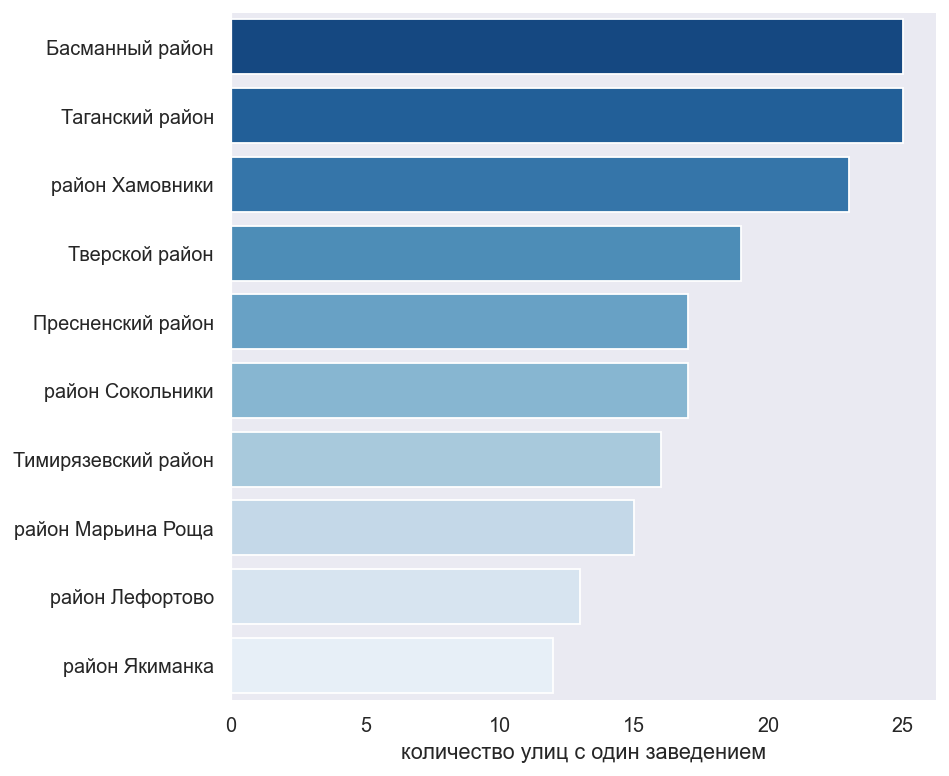

In [54]:
plt.figure(figsize=(7,7),dpi=130)

sns.set_style("dark")
ax = sns.barplot(districts.values,districts.index,
            palette='Blues_r',saturation=0.8)
ax.set(xlabel='количество улиц с один заведением', ylabel='')
sns.despine(bottom=True)

Лидеры по количеству улиц с одним объектом общепита – Басманный и Таганский районы, далее следуют Хамовники и Тверской район. Все районы (за исключением Тимирязевского и Марьиной Рощи) граничат с Садовым Кольцом

# ВЫВОД

Кафе – самый распространённый тип заведений общественного питания в Москве, далее следуют рестораны и столовые. 
<p>Из сетевых предприятий, чья распространённость в Москве невелика, по количеству заведений лидируют так же кафе, а по доле сетей в категории – фастфуд. 
<p>Наименьшая доля сетевых точек наблюдается у столовых (0.2%). 
<p>Сетям свойственно иметь от 2 до 4 адресов в городе c количеством посадочных мест от 22 до 75
<p>Самый вместительный вид общепита – столовые, в среднем там 140 посадочных мест. Далее со значительным отрывом идут рестораны (100) и буфеты (60). Средняя вместительность кафе – 41 посадочное место.
<p>Улицы с наибольшим количеством заведений общепита находятся за пределами 3-го транспортного кольца (исключение – Кутузовский проспект и Пресненская набережная). На таких улицах заведения чаще предлагают меньшее количество посадочных мест.
<p>А районы-лидеры по количеству улиц с одним объектом общепита находятся близко к центру Москвы

Чтобы окупить дорогой проект, вероятно, понадобится увеличить оборот гостей в кафе и, следовательно, количество посадочных мест. Чтобы это осуществить и не сильно выбиваться из окружения, возможно, следует избегать улиц за Третьим транспортным кольцом – среднее количество посадочных мест там ниже.
Чтобы избежать высокой конкуренции, стоит обратить внимание на улицы с одним объектом общепита. Их наибольшая концентрация – между Третьим транспортным и Садовым кольцами.
Если планируется расширение до сети, двух-четырёх точек может быть вполне достаточно. И вообще не факт, что это необходимо – менее трети всех кафе в Москве – сетевые.